In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [3]:
torch.cuda.set_device(0)

In [4]:
dls = get_seutao_dls_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


## Load

In [6]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [7]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
#         d_model = 2048+6+1
        d_model = 2048
        n_head = 4
#         self.linear = nn.Linear(d_model+7, d_model)
        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_model*2)
        self.transformer = TransformerEncoder(encoder_layers, 4)
        
        self.head = nn.Sequential(nn.Linear(d_model,6))
        
    def forward(self, x):
        x,x_p,x_m = x
#         x = torch.cat(x, axis=-1)
#         x = self.linear(x)
        feat = self.transformer(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [8]:
m = SeqHead().cuda()
name = 'seutao_transformer'
learn = get_learner(dls, m)
learn.add_cb(DePadLoss())

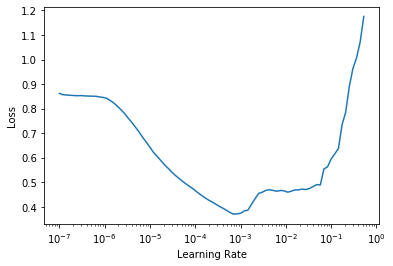

In [9]:
learn.lr_find()

## Train

In [12]:
do_fit(learn, 6, 1e-4)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.072450,None,None,None,00:37
1,0.063845,None,None,None,00:37
2,0.063693,None,None,None,00:37
3,0.060875,None,None,None,00:37
4,0.057043,None,None,None,00:37
5,0.056880,None,None,None,00:37


/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Submit

In [17]:
learn.dls = get_seutao_dls_meta(Meta.df_tst, np_file_test, csv_file_test, bs=1, test=True)
learn.load(f'runs/{name}-1')
preds,targs = learn.get_preds()

loading features
Done loading features


In [18]:
# df_series = Meta.df_tst.sort_values(['SeriesInstanceUID', "ImagePositionPatient2"])
sub_fn = f'subm/{name}'
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)
api.competition_submit(f'{sub_fn}.csv', sub_fn, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 10.6MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [19]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14346539,
 'totalBytes': 27277209,
 'date': '2020-01-31T23:29:11.873Z',
 'description': 'subm/seutao_transformer',
 'errorDescription': None,
 'fileName': 'seutao_transformer.csv',
 'publicScore': '1.53277',
 'privateScore': '0.06008',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14346539/14346539.raw'}

In [16]:
xb,yb = dls_test.one_batch()

In [20]:
submit_predictions(m, f'runs/{name}-1', f'subm/{name}', 'testing seutao features - transformer', dfunc=get_seutao_dls_meta)

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:02<00:00, 10.0MB/s]


In [21]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14346503,
 'totalBytes': 27277209,
 'date': '2020-01-31T23:19:31.58Z',
 'description': 'testing seutao features - transformer',
 'errorDescription': None,
 'fileName': 'seutao_transformer.csv',
 'publicScore': '1.53277',
 'privateScore': '0.06008',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14346503/14346503.raw'}